In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split

In [ ]:

file_path = "/content/reviews.csv"
# Read CSV file and assign column names manually if no headers exist
column_names = [
    "id", "asins", "brand", "categories", "colors", "date_added", "date_updated", "dimension", "ean", "keys",
    "manufacturer", "manufacturer_number", "name", "primary_category", "source", "upc", "weight", "reviews_rating",
    "reviews_text", "reviews_title", "reviews_date", "reviews_user", "reviews_source_urls", "reviews_verified", "price", "currency", "availability"
]  # Adjust column names as needed

df = pd.read_csv(file_path, header=None, names=column_names)

# Display first few rows
print(df.head())

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)

# Remove empty reviews
df = df[df['reviews_text'].str.strip() != '']

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Ensure 'reviews_text' exists and clean it
df['reviews_text'] = df['reviews_text'].astype(str)
df['cleaned_reviews'] = df['reviews_text'].apply(clean_text)

# Convert ratings to numeric and create sentiment labels
df['reviews_rating'] = pd.to_numeric(df['reviews_rating'], errors='coerce')  # Ensure numeric ratings
df.dropna(subset=['reviews_rating'], inplace=True)  # Remove rows where ratings are NaN
df['sentiment'] = df['reviews_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Tokenization and padding
MAX_NUM_WORDS = 100000  # Increased vocabulary size
MAX_SEQUENCE_LENGTH = 1200  # Increased sequence length
EMBEDDING_DIM = 400  # Increased embedding dimension

# Tokenization
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_reviews'])
sequences = tokenizer.texts_to_sequences(df['cleaned_reviews'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Ensure X and y have the same length
if len(padded_sequences) != len(df['sentiment']):
    min_length = min(len(padded_sequences), len(df['sentiment']))
    padded_sequences = padded_sequences[:min_length]
    df = df.iloc[:min_length]


                     id       asins   brand                  categories  \
0                    id       asins   brand                  categories   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

   colors            date_added          date_updated  \
0  colors             dateAdded           dateUpdated   
1     NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2     NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3     NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4     NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0                 dimension  ean                         keys  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(941, 1200)
(236, 1200)
(941,)
(236,)


In [ ]:
model2 = Sequential([
    Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

    Bidirectional(LSTM(512, return_sequences=True)),  # Increased LSTM units
    Dropout(0.3),  # Reduced dropout

    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.3),

    LSTM(128),
    Dropout(0.3),

    Dense(256, activation='relu'),  # Increased neurons
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    Dense(1, activation='sigmoid')  # Binary classification
])

# Explicitly build model
model2.build(input_shape=(None, MAX_SEQUENCE_LENGTH))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Use learning rate decay for better optimization
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,  # Slightly higher initial LR
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# Optimizer with RMSprop (better for LSTMs) + Gradient Clipping
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, clipnorm=1.0)

# Compile the model with a lower learning rate and AUC metric
model2.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.AUC(name="AUC")]
)

# Explicitly build model
model2.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Print summary
model2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1200, 400)           │      40,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1200, 1024)          │       3,739,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1200, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1200, 512)           │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1200, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,765,569 (178.40 MB)

 Trainable params: 46,765,569 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model2.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
results = model2.evaluate(X_test, y_test)  # Store all returned values

# Unpack only loss and accuracy (ignore extra returned values)
loss, accuracy = results[:2]

# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - AUC: 0.5320 - accuracy: 0.7250 - loss: 0.5931 - val_AUC: 0.5000 - val_accuracy: 0.8475 - val_loss: 0.4348
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - AUC: 0.4134 - accuracy: 0.8123 - loss: 0.5110 - val_AUC: 0.5000 - val_accuracy: 0.8475 - val_loss: 0.4322
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - AUC: 0.4944 - accuracy: 0.8255 - loss: 0.4684 - val_AUC: 0.5000 - val_accuracy: 0.8475 - val_loss: 0.4331
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.4512 - accuracy: 0.8392 - loss: 0.4509 - val_AUC: 0.5000 - val_accuracy: 0.8475 - val_loss: 0.4551
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - AUC: 0.4198 - accuracy: 0.8437 - loss: 0.4522 - val_AUC: 0.5000 - val_accuracy: 0.8475 - val_loss: 0.4487
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - AUC: 0.4625 - accuracy: 0.8303 - loss: 0.4649 - val_AUC: 0.5000 - val_accuracy: 0.8475 - val_loss: 0.4272
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - 

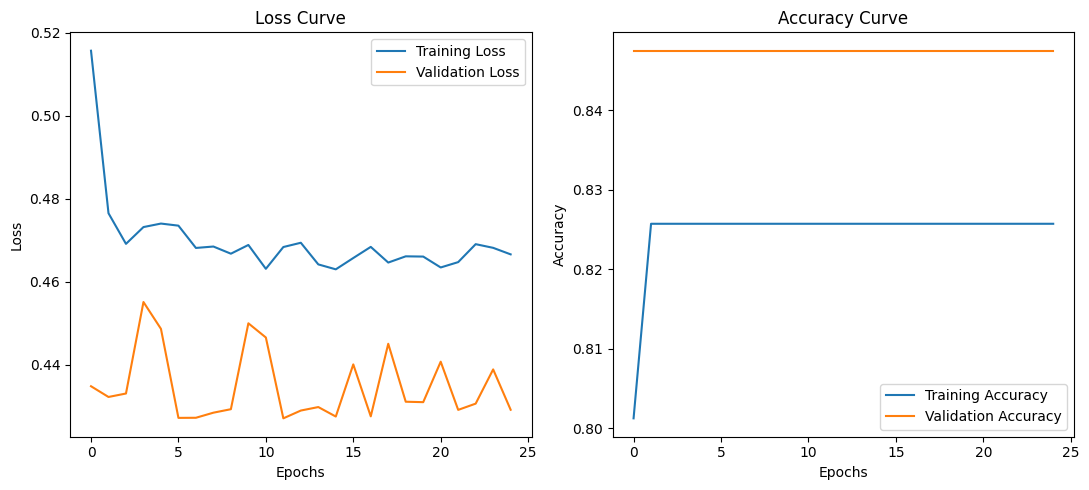

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(11, 5))

# Plot Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.85      1.00      0.92       200

    accuracy                           0.85       236
   macro avg       0.42      0.50      0.46       236
weighted avg       0.72      0.85      0.78       236

Precision: 0.8475
Recall: 1.0000
F1-score: 0.9174


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


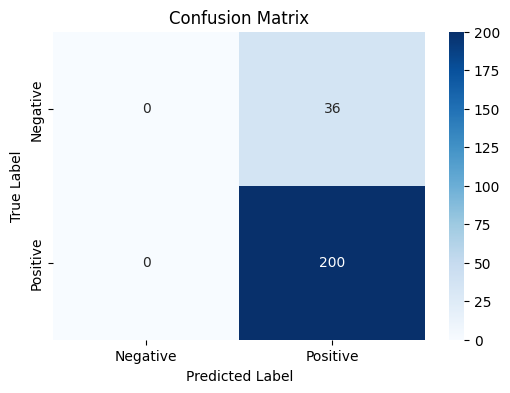

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


class_names = ['positive','negative']


# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save the model
model2.save("amazon_review_lstm.h5")
